# Feature Extraction - waveform analysis

## Waveforms - span grip data

### Wavelet Analysis

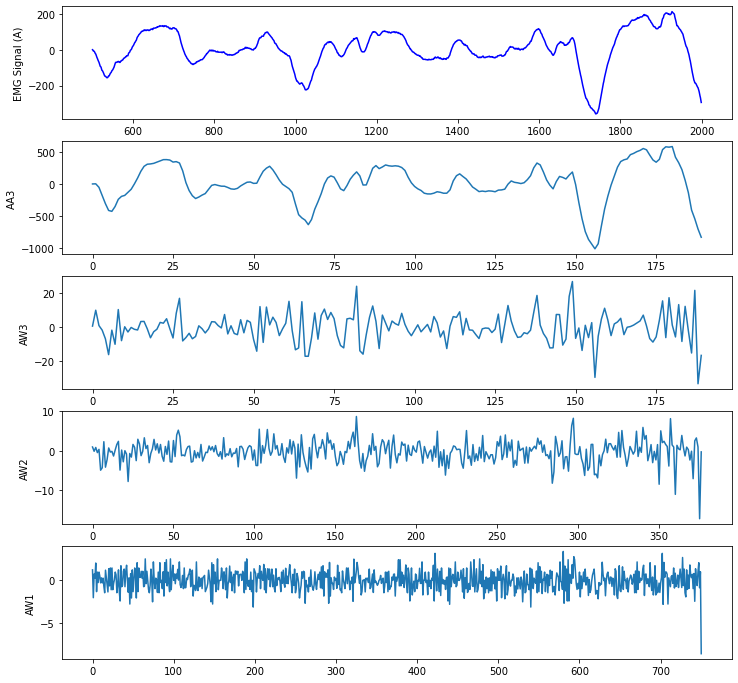

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pandas as pd
import math


data =  pd.read_csv('C:/Users/CEPlus/Desktop/HPID13_New/Train/subject-train/Divya-span-1.csv')

data_A = data.iloc[500:2000,3]
A_coeffs = pywt.wavedec(data_A, 'db2', level=3)
AA3, AW3, AW2, AW1 = A_coeffs

fig, axs = plt.subplots(5, figsize=(12,12))
axs[0].plot(data_A,'b')
axs[0].set_ylabel('EMG Signal (A)')
axs[1].plot(AA3)
axs[1].set_ylabel('AA3')
axs[2].plot(AW3)
axs[2].set_ylabel('AW3')
axs[3].plot(AW2)
axs[3].set_ylabel('AW2')
axs[4].plot(AW1)
axs[4].set_ylabel('AW1')

plt.show()

### Notch filter, band-pass-filter

In [2]:
def notch_filter(x, samplerate, plot=False):
 
    x = x - np.mean(x)

    high_cutoff_notch = 49 / (samplerate / 2)
    low_cutoff_notch = 51 / (samplerate / 2)

    # Band Stop Filter (BSF) or Band Reject Filter
    [b, a] = signal.butter(4, [high_cutoff_notch, low_cutoff_notch], btype='stop')

    x_filt = signal.filtfilt(b, a, x.T)

    if plot:
        t = np.arange(0, len(x) / samplerate, 1 / samplerate)
        plt.plot(t, x)
        plt.plot(t, x_filt.T, 'k')
        plt.legend(['Original', 'Filtered'], loc = 'best')
        plt.autoscale(tight=True)
        plt.xlabel('Time')
        plt.ylabel('Amplitude (mV)')
        plt.show()

    return x_filt


def bp_filter(x, low_f, high_f, samplerate, plot=False):
    # x = x - np.mean(x)

    low_cutoff_bp = low_f / (samplerate / 2)
    high_cutoff_bp = high_f / (samplerate / 2)

    [b, a] = signal.butter(5, [low_cutoff_bp, high_cutoff_bp], btype='bandpass')

    x_filt = signal.filtfilt(b, a, x)
    #print(len(x))

    if plot:
        t = np.arange(0, len(x.transpose()) / samplerate, 1 / samplerate)
        plt.plot(t, x.transpose())
        plt.plot(t, x_filt.transpose(), 'k')
        plt.legend(['Original', 'Filtered'], loc = 'best')
        plt.autoscale(tight=True)
        plt.xlabel('Time')
        plt.ylabel('Amplitude (mV)')
        plt.show()

    return x_filt

### Frequency band analysis

In [3]:
def plot_freq_band (data_in):
    fs = 512                                # Sampling rate (512 Hz)
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data_in))
    
    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data_in), 1.0/fs)
    #print(fft_freq)
    # Define EMG bands
    emg_bands = {' 0 - 10Hz': (0, 10),
                 '11 - 20Hz': (11, 20),
                 '21 - 30Hz': (21, 30),
                 '31 - 40Hz': (31, 40),
                 '41 - 50Hz': (41, 50)}
                # '45 to 100 Hz':(45,100),
                 #'101 to 200 Hz':(101,200)}

    # Take the mean of the fft amplitude for each EMG band
    emg_band_fft = dict()
    for band in emg_bands:  
        freq_ix = np.where((fft_freq >= emg_bands[band][0]) & 
                           (fft_freq <= emg_bands[band][1]))[0]
        emg_band_fft[band] = np.mean(fft_vals[freq_ix])

    # Plot the data (using pandas here cause it's easy)
    import pandas as pd
    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = emg_bands.keys()
    df['val'] = [emg_band_fft[band] for band in emg_bands]
    ax = df.plot.bar(x='band', y='val', legend=False)
    ax.set_xlabel("EMG band")
    ax.set_ylabel("Mean band Amplitude")

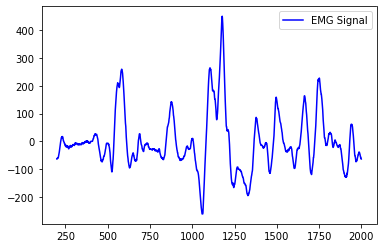

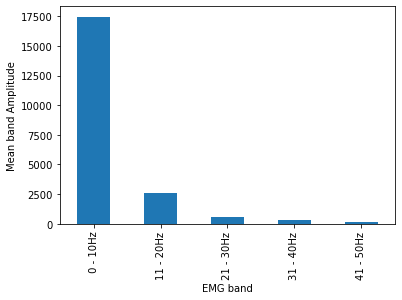

In [4]:

import scipy
import scipy.signal
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

#data =  pd.read_csv('C:/Users/ajay/Documents/EMG_Emotion/EMG_Emotion_data/name-concentrating-1.csv')
#data =  pd.read_csv('C:/Users/ajay/Documents/EMG_Emotion/EMG_Emotion_data/Disgust_state.csv')
#data =  pd.read_csv('C:/Users/ajay/Documents/EMG_Emotion/EMG_Emotion_data/Happy_state.csv')
#data =  pd.read_csv('C:/Users/ajay/Documents/EMG_Emotion/EMG_Emotion_data/subjectb-relaxed-1.csv')


data_A = data.iloc[200:3799,2]
plt.clf()
plt.plot(data_A,'b')
plt.legend(['EMG Signal'], loc = 'best')
plot_freq_band (data_A)
#plt.clf()


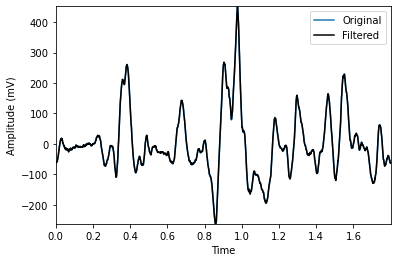

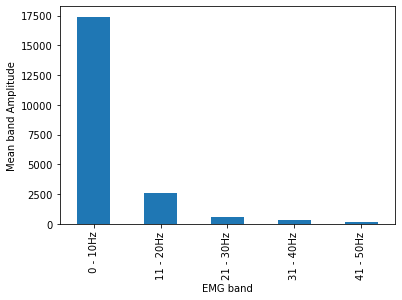

In [5]:
notch_out = notch_filter(data_A, samplerate=1000, plot=True)
#plt.clf()
plot_freq_band (notch_out)
#plt.clf()

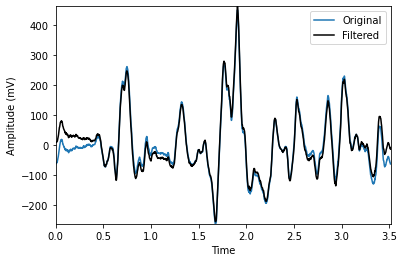

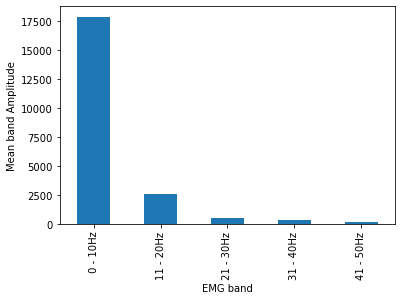

In [6]:
bp_out =  bp_filter(notch_out, low_f=.5, high_f=200, samplerate=512, plot=True)
#plt.clf()
plot_freq_band (bp_out)

### power spectral density

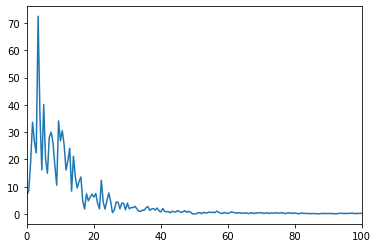

In [7]:
#Power spectral density
from scipy.fftpack import fft, fftfreq
import matplotlib.pyplot as plt
x= bp_out
dt = 0.001
#X = fft(x)
X=fft(x)/len(x)
freq = fftfreq(x.size, d=dt)

# Only keep positive frequencies.
keep = freq>=0
#X = X[keep]
X=X[keep]*2
freq = freq[keep]

ax1 = plt.subplot(111)
ax1.plot(freq, np.absolute(X))#/3000.)
ax1.set_xlim(0,100)

plt.show()

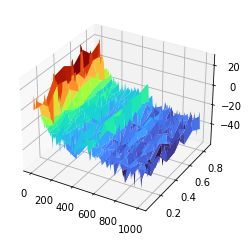

In [8]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal # spectrogram function
from matplotlib import cm # colour map

mysignal =data.iloc[:,1] # CHANGE THE SIGNAL AND SEE PLOT

# basic config
sample_rate = 2000 #11240.  # 
sig_len_secs = 10
frequency = 2000.

# generate thetimepoint
timestamps_secs = np.arange(sample_rate*sig_len_secs) / sample_rate


# extract the spectrum
freq_bins, timestamps, spec = signal.spectrogram(mysignal, sample_rate)

# 3d plot

fig = plt.figure()
#ax = fig.gca(projection='3d')
ax = plt.subplot(1,1,1,projection="3d"); 
ax.plot_surface(freq_bins[:, None], timestamps[None, :], 10.0*np.log10(spec), cmap=cm.turbo)
plt.show()


### Windowing technique

(1899,)


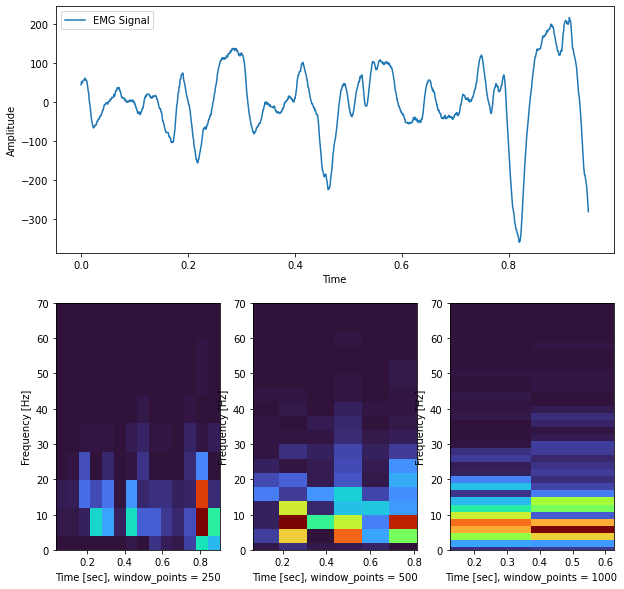

In [9]:
#https://stackoverflow.com/questions/72181057/what-is-the-ideal-parameters-for-spectrogram-of-emg-signal
#Windowing of signal for analysis and discussion of no of datapoints 
# We clim 500 to be the ideal number of data points 
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

#y_data = np.genfromtxt('signal_value_spectro.csv', delimiter=',',skip_header=0)

Oz=data.iloc[100:1999,3]#
fs = 2000
t = np.arange(len(Oz))/fs

print(t.shape)
# nperseg = len(Oz[0])-1
#nperseg=50
#f50, t50, Sxx_50 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg-1,window=signal.get_window('hann',nperseg))
#nperseg=150
#f150, t150, Sxx_150 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg-1,window=signal.get_window('hann',nperseg))
#nperseg=350
#f350, t350, Sxx_350 = signal.spectrogram(Oz, fs, nperseg=nperseg , noverlap=nperseg-1,window=signal.get_window('hann',nperseg))

nperseg=250
f250, t250, Sxx_250 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
nperseg=500
f500, t500, Sxx_500 = signal.spectrogram(Oz, fs, nperseg=nperseg , noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
nperseg=1000
f1000, t1000, Sxx_1000 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
#50% OVERLAP FOR ALL 3 
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(np.arange(len(Oz))/fs,Oz)  
plt.legend(['EMG Signal'], loc = 'best')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.subplot(234)
plt.pcolormesh(t250, f250, Sxx_250, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], window_points = 250')
plt.subplot(235)
plt.pcolormesh(t500, f500, Sxx_500, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], window_points = 500')
plt.subplot(236)
plt.pcolormesh(t1000, f1000, Sxx_1000, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], window_points = 1000')


plt.show()

(1899,)


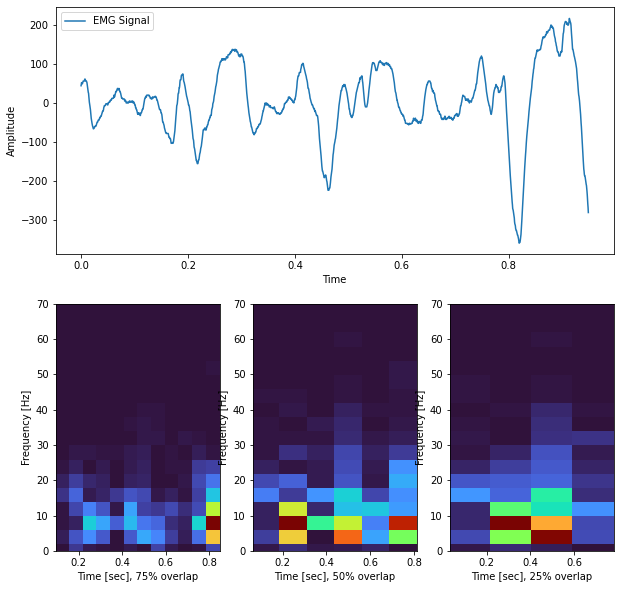

In [10]:
#https://stackoverflow.com/questions/72181057/what-is-the-ideal-parameters-for-spectrogram-of-emg-signal
#  overlapping of signal analysis and discussion of lenght of overlapping window
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

#y_data = np.genfromtxt('signal_value_spectro.csv', delimiter=',',skip_header=0)

Oz=data.iloc[100:1999,3]#
fs = 2000
t = np.arange(len(Oz))/fs

print(t.shape)

nperseg=500
f250, t250, Sxx_250 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//1.334,window=signal.get_window('hann',nperseg))
nperseg=500
f500, t500, Sxx_500 = signal.spectrogram(Oz, fs, nperseg=nperseg , noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
nperseg=500
f1000, t1000, Sxx_1000 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//4,window=signal.get_window('hann',nperseg))
#ALL 3 have  500 Datapoints 
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(np.arange(len(Oz))/fs,Oz)  
plt.legend(['EMG Signal'], loc = 'best')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.subplot(234)
plt.pcolormesh(t250, f250, Sxx_250, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], 75% overlap')
plt.subplot(235)
plt.pcolormesh(t500, f500, Sxx_500, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], 50% overlap')
plt.subplot(236)
plt.pcolormesh(t1000, f1000, Sxx_1000, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], 25% overlap')


plt.show()

An appropriate amount of overlap will depend on the choice of window and on your requirements. In contrast to welch’s method, where the entire data stream is averaged over, one may wish to use a smaller overlap (or perhaps none at all) when computing a spectrogram, to maintain some statistical independence between individual segments. It is for this reason that the default window is a Tukey window with 1/8th of a window’s length overlap at each end.

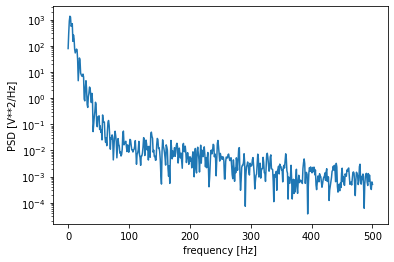

In [11]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html
# default Hann window an overlap of 50% 
#Compute and plot the power spectral density.
from scipy import signal
import matplotlib.pyplot as plt
rng = np.random.default_rng()
fs = 1000
x=data.iloc[100:2999,3]
f, Pxx_den = signal.welch(x, fs, nperseg=1024)
plt.semilogy(f, Pxx_den)
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

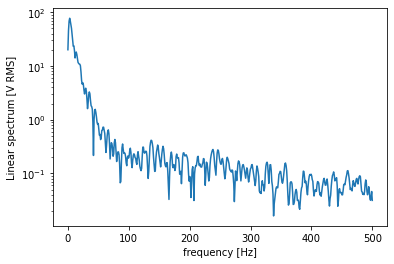

In [12]:
#compute and plot the power spectrum.
f, Pxx_spec = signal.welch(x, fs, 'flattop', 1024, scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()

## Waveforms - Hook grip data

### Wavelet transform 

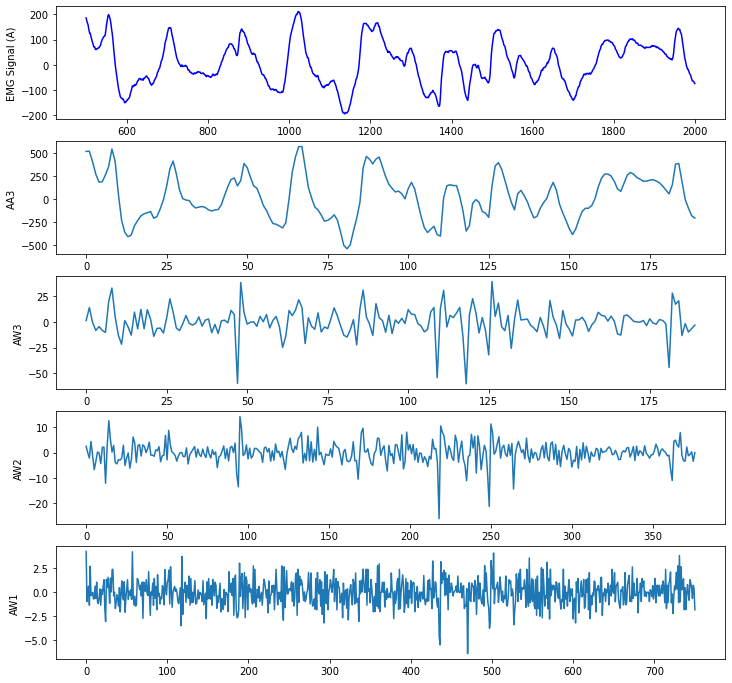

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pandas as pd
import math


data =  pd.read_csv('C:/Users/CEPlus/Desktop/HPID13_New/Train/subject-train/Divya-hook-1.csv')

data_A = data.iloc[500:2000,3]
A_coeffs = pywt.wavedec(data_A, 'db2', level=3)
AA3, AW3, AW2, AW1 = A_coeffs

fig, axs = plt.subplots(5, figsize=(12,12))
axs[0].plot(data_A,'b')
axs[0].set_ylabel('EMG Signal (A)')
axs[1].plot(AA3)
axs[1].set_ylabel('AA3')
axs[2].plot(AW3)
axs[2].set_ylabel('AW3')
axs[3].plot(AW2)
axs[3].set_ylabel('AW2')
axs[4].plot(AW1)
axs[4].set_ylabel('AW1')

plt.show()

### Notch filter, band-pass filter

In [3]:
def notch_filter(x, samplerate, plot=False):
 
    x = x - np.mean(x)

    high_cutoff_notch = 49 / (samplerate / 2)
    low_cutoff_notch = 51 / (samplerate / 2)

    # Band Stop Filter (BSF) or Band Reject Filter
    [b, a] = signal.butter(4, [high_cutoff_notch, low_cutoff_notch], btype='stop')

    x_filt = signal.filtfilt(b, a, x.T)

    if plot:
        t = np.arange(0, len(x) / samplerate, 1 / samplerate)
        plt.plot(t, x)
        plt.plot(t, x_filt.T, 'k')
        plt.legend(['Original', 'Filtered'], loc = 'best')
        plt.autoscale(tight=True)
        plt.xlabel('Time')
        plt.ylabel('Amplitude (mV)')
        plt.show()

    return x_filt


def bp_filter(x, low_f, high_f, samplerate, plot=False):
    # x = x - np.mean(x)

    low_cutoff_bp = low_f / (samplerate / 2)
    high_cutoff_bp = high_f / (samplerate / 2)

    [b, a] = signal.butter(5, [low_cutoff_bp, high_cutoff_bp], btype='bandpass')

    x_filt = signal.filtfilt(b, a, x)
    #print(len(x))

    if plot:
        t = np.arange(0, len(x.transpose()) / samplerate, 1 / samplerate)
        plt.plot(t, x.transpose())
        plt.plot(t, x_filt.transpose(), 'k')
        plt.legend(['Original', 'Filtered'], loc = 'best')
        plt.autoscale(tight=True)
        plt.xlabel('Time')
        plt.ylabel('Amplitude (mV)')
        plt.show()

    return x_filt

### Frequency band analysis 

In [4]:
def plot_freq_band (data_in):
    fs = 512                                # Sampling rate (512 Hz)
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data_in))
    
    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data_in), 1.0/fs)
    #print(fft_freq)
    # Define EMG bands
    emg_bands = {' 0 - 10Hz': (0, 10),
                 '11 - 20Hz': (11, 20),
                 '21 - 30Hz': (21, 30),
                 '31 - 40Hz': (31, 40),
                 '41 - 50Hz': (41, 50)}
                # '45 to 100 Hz':(45,100),
                 #'101 to 200 Hz':(101,200)}

    # Take the mean of the fft amplitude for each EMG band
    emg_band_fft = dict()
    for band in emg_bands:  
        freq_ix = np.where((fft_freq >= emg_bands[band][0]) & 
                           (fft_freq <= emg_bands[band][1]))[0]
        emg_band_fft[band] = np.mean(fft_vals[freq_ix])

    # Plot the data (using pandas here cause it's easy)
    import pandas as pd
    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = emg_bands.keys()
    df['val'] = [emg_band_fft[band] for band in emg_bands]
    ax = df.plot.bar(x='band', y='val', legend=False)
    ax.set_xlabel("EMG band")
    ax.set_ylabel("Mean band Amplitude")

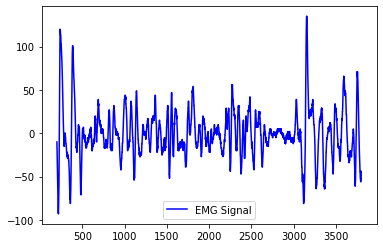

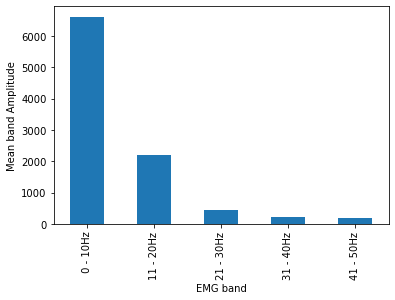

In [5]:
import scipy
import scipy.signal
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

#data =  pd.read_csv('C:/Users/ajay/Documents/EMG_Emotion/EMG_Emotion_data/name-concentrating-1.csv')
#data =  pd.read_csv('C:/Users/ajay/Documents/EMG_Emotion/EMG_Emotion_data/Disgust_state.csv')
#data =  pd.read_csv('C:/Users/ajay/Documents/EMG_Emotion/EMG_Emotion_data/Happy_state.csv')
#data =  pd.read_csv('C:/Users/ajay/Documents/EMG_Emotion/EMG_Emotion_data/subjectb-relaxed-1.csv')


data_A = data.iloc[200:3799,2]
plt.clf()
plt.plot(data_A,'b')
plt.legend(['EMG Signal'], loc = 'best')
plot_freq_band (data_A)
#plt.clf()


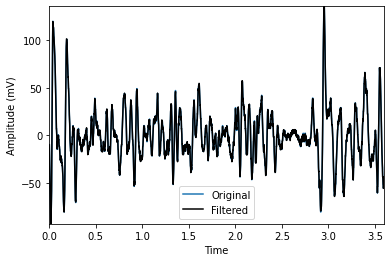

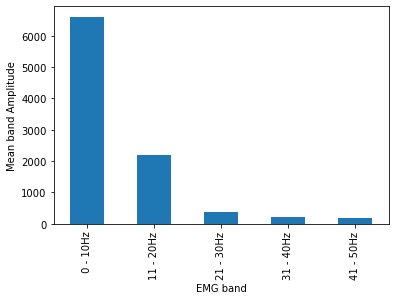

In [6]:
notch_out = notch_filter(data_A, samplerate=1000, plot=True)
#plt.clf()
plot_freq_band (notch_out)
#plt.clf()

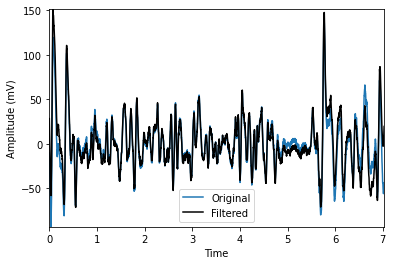

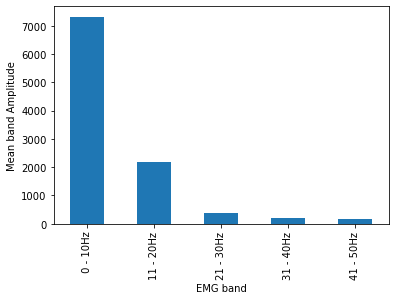

In [7]:
bp_out =  bp_filter(notch_out, low_f=.5, high_f=200, samplerate=512, plot=True)
#plt.clf()
plot_freq_band (bp_out)

### Power spectral density

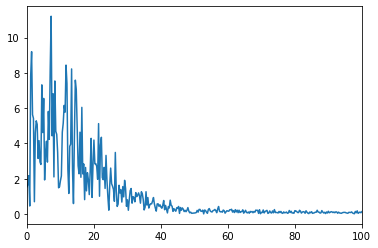

In [8]:
#Power spectral density
from scipy.fftpack import fft, fftfreq
import matplotlib.pyplot as plt
x= bp_out
dt = 0.001
#X = fft(x)
X=fft(x)/len(x)
freq = fftfreq(x.size, d=dt)

# Only keep positive frequencies.
keep = freq>=0
#X = X[keep]
X=X[keep]*2
freq = freq[keep]

ax1 = plt.subplot(111)
ax1.plot(freq, np.absolute(X))#/3000.)
ax1.set_xlim(0,100)

plt.show()

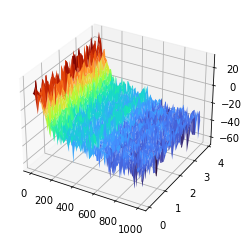

In [9]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal # spectrogram function
from matplotlib import cm # colour map

mysignal =data.iloc[:,1] # CHANGE THE SIGNAL AND SEE PLOT

# basic config
sample_rate = 2000 #11240.  # 
sig_len_secs = 10
frequency = 2000.

# generate thetimepoint
timestamps_secs = np.arange(sample_rate*sig_len_secs) / sample_rate


# extract the spectrum
freq_bins, timestamps, spec = signal.spectrogram(mysignal, sample_rate)

# 3d plot

fig = plt.figure()
#ax = fig.gca(projection='3d')
ax = plt.subplot(1,1,1,projection="3d"); 
ax.plot_surface(freq_bins[:, None], timestamps[None, :], 10.0*np.log10(spec), cmap=cm.turbo)
plt.show()


### Windowing technique 

(1899,)


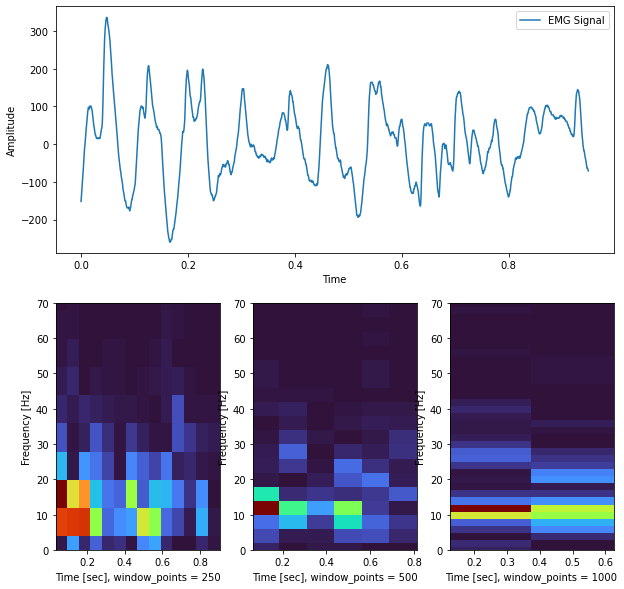

In [10]:
#https://stackoverflow.com/questions/72181057/what-is-the-ideal-parameters-for-spectrogram-of-emg-signal
#Windowing of signal for analysis and discussion of no of datapoints 
# We clim 500 to be the ideal number of data points 
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

#y_data = np.genfromtxt('signal_value_spectro.csv', delimiter=',',skip_header=0)

Oz=data.iloc[100:1999,3]#
fs = 2000
t = np.arange(len(Oz))/fs

print(t.shape)
# nperseg = len(Oz[0])-1
#nperseg=50
#f50, t50, Sxx_50 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg-1,window=signal.get_window('hann',nperseg))
#nperseg=150
#f150, t150, Sxx_150 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg-1,window=signal.get_window('hann',nperseg))
#nperseg=350
#f350, t350, Sxx_350 = signal.spectrogram(Oz, fs, nperseg=nperseg , noverlap=nperseg-1,window=signal.get_window('hann',nperseg))

nperseg=250
f250, t250, Sxx_250 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
nperseg=500
f500, t500, Sxx_500 = signal.spectrogram(Oz, fs, nperseg=nperseg , noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
nperseg=1000
f1000, t1000, Sxx_1000 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
#50% OVERLAP FOR ALL 3 
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(np.arange(len(Oz))/fs,Oz)  
plt.legend(['EMG Signal'], loc = 'best')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.subplot(234)
plt.pcolormesh(t250, f250, Sxx_250, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], window_points = 250')
plt.subplot(235)
plt.pcolormesh(t500, f500, Sxx_500, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], window_points = 500')
plt.subplot(236)
plt.pcolormesh(t1000, f1000, Sxx_1000, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], window_points = 1000')


plt.show()

(1899,)


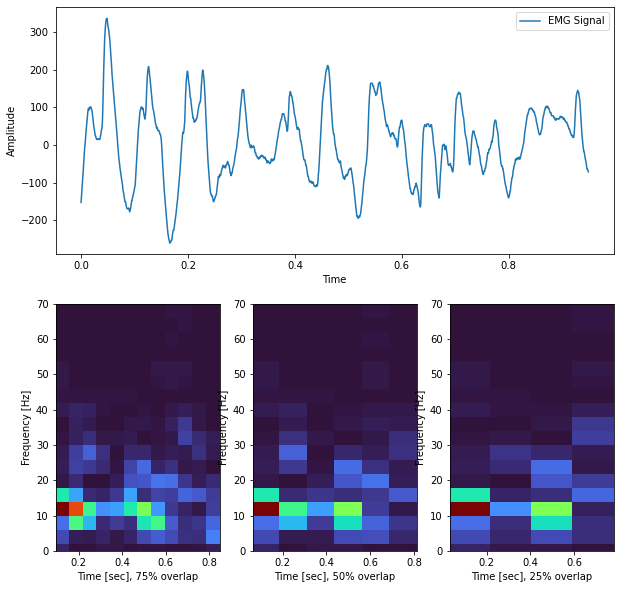

In [11]:
#https://stackoverflow.com/questions/72181057/what-is-the-ideal-parameters-for-spectrogram-of-emg-signal
#  overlapping of signal analysis and discussion of lenght of overlapping window
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

#y_data = np.genfromtxt('signal_value_spectro.csv', delimiter=',',skip_header=0)

Oz=data.iloc[100:1999,3]#
fs = 2000
t = np.arange(len(Oz))/fs

print(t.shape)

nperseg=500
f250, t250, Sxx_250 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//1.334,window=signal.get_window('hann',nperseg))
nperseg=500
f500, t500, Sxx_500 = signal.spectrogram(Oz, fs, nperseg=nperseg , noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
nperseg=500
f1000, t1000, Sxx_1000 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//4,window=signal.get_window('hann',nperseg))
#ALL 3 have  500 Datapoints 
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(np.arange(len(Oz))/fs,Oz)  
plt.legend(['EMG Signal'], loc = 'best')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.subplot(234)
plt.pcolormesh(t250, f250, Sxx_250, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], 75% overlap')
plt.subplot(235)
plt.pcolormesh(t500, f500, Sxx_500, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], 50% overlap')
plt.subplot(236)
plt.pcolormesh(t1000, f1000, Sxx_1000, shading='auto',cmap = 'turbo')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], 25% overlap')


plt.show()

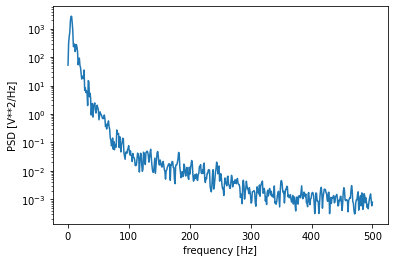

In [12]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html
# default Hann window an overlap of 50% 
#Compute and plot the power spectral density.
from scipy import signal
import matplotlib.pyplot as plt
rng = np.random.default_rng()
fs = 1000
x=data.iloc[100:2999,3]
f, Pxx_den = signal.welch(x, fs, nperseg=1024)
plt.semilogy(f, Pxx_den)
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

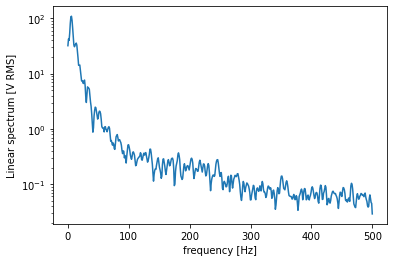

In [13]:
#compute and plot the power spectrum.
f, Pxx_spec = signal.welch(x, fs, 'flattop', 1024, scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()